In [38]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from scipy.spatial.distance import cdist
from tqdm import tqdm

In [ ]:
coord_df = pd.read_csv("../data/school_coordinates.csv")

coord_df[['Lat','Lon']] = coord_df.geo_coordinates.str.split(",", expand=True)

coord_df['Lat'] = coord_df['Lat'].astype('double')
coord_df['Lon'] = coord_df['Lon'].astype('double')
coord_df['point'] = [(x, y) for x,y in zip(coord_df['Lat'], coord_df['Lon'])]

coord_df

In [56]:
ds = xr.load_dataset("../data/surface/temp_deg1_24.nc")

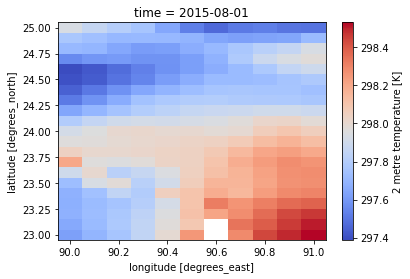

In [58]:
ds.t2m[0].plot(cmap=plt.cm.coolwarm)

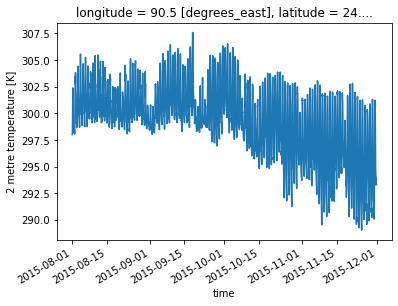

In [59]:
ds.t2m.sel(longitude=90.5, latitude=24).plot()

In [60]:
df = ds.to_dataframe().reset_index()
df.head()

,longitude,latitude,time,t2m
0,90.0,25.0,2015-08-01 00:00:00,297.935150
1,90.0,25.0,2015-08-01 01:00:00,297.701569
2,90.0,25.0,2015-08-01 02:00:00,297.674286
3,90.0,25.0,2015-08-01 03:00:00,297.887329
4,90.0,25.0,2015-08-01 04:00:00,298.033081


In [ ]:
print(df.longitude.unique())
print(df.latitude.unique())

In [ ]:
df = (
    df.assign(
        date = lambda d: d.time.dt.date,
        year = lambda d: d.time.dt.year,
        month = lambda d: d.time.dt.month,
        day = lambda d: d.time.dt.day,
        hour = lambda d: d.time.dt.hour,
        temperature = lambda d: d.t2m - 273.15
    )
)
df['point'] = [(x, y) for x,y in zip(df['latitude'], df['longitude'])]
df.head()

In [63]:
def closest_point(point, points):
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    return df[df[col1] == x][col2].values[0]

main_df = pd.DataFrame(columns = ['slno', 'area', 'name_school', 'TempRate'])

for d in tqdm(range(len(df.time.unique()))):

    date_hour = df.time.unique()[d]

    _df = df[df.time == date_hour]

    coord_df['closest'] = [closest_point(x, list(_df['point'])) for x in coord_df['point']]
    coord_df['TempRate'] = [match_value(_df, 'point', x, ['temperature', 'time']) for x in coord_df['closest']]

    _coord_df = coord_df[['slno', 'area', 'name_school', 'TempRate']]

    main_df = pd.concat([main_df, _coord_df], axis = 0)

100%|██████████| 2928/2928 [01:17<00:00, 37.97it/s]


In [ ]:
main_df[['temperature','time']] = pd.DataFrame(main_df.TempRate.tolist(), index= main_df.index)
main_df.head()

<AxesSubplot:>

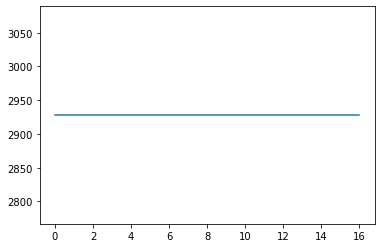

In [65]:
plot_df = (
    main_df.assign(
        date = lambda d: d.time
    )
    .sort_values('date')
)

count_df = plot_df.groupby(level=0)['temperature'].count()

fig, ax = plt.subplots()
count_df.plot(kind="line", y="temperature", ax=ax)

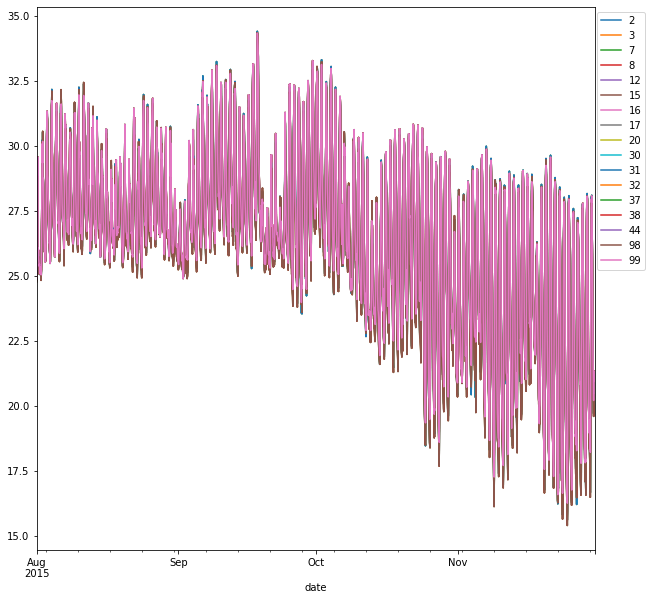

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
for i, g in plot_df.groupby("slno"):
    g.plot(kind="line", x = 'date', y="temperature", ax=ax, label=i)
lgd = ax.legend(loc = 1, bbox_to_anchor=(1.1, 1.0))

fig.savefig('temperature', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 300)

In [67]:
main_df.to_csv("../data/surface/main.csv")